# **Data Diri**
- Nama: Muhammad Arya Java
- Username: aryajv
- Email: muhammad.aryajava@gmail.com
- LinkedIn: https://www.linkedin.com/in/aryajv
- Pendidikan Terakhir: Strata-1
- Pekerjaan/ Profesi Saat Ini: Pelajar/ Mahasiswa
- Institusi: Universitas Budi Luhur

# **Import Library**

In [1]:
import zipfile
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from google.colab import files

# **Download dan Ekstrak Dataset**

---



In [2]:
file_path = "/content/rockpaperscissors.zip"
if os.path.exists(file_path):
    print("File Sudah Sudah Ada!")
else:
  !wget https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip

with zipfile.ZipFile("rockpaperscissors.zip", "r") as zip_ref:
  zip_ref.extractall("/tmp")
  zip_ref.close()

base_dir = "/tmp/rockpaperscissors/rps-cv-images"

File Sudah Sudah Ada!


# **Augmentasi Gambar Menggunakan ImageDataGenerator**

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.4, 1.6],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="reflect",
    validation_split = 0.4,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.4,
)

# **Menggunakan ImageDataGenerator Untuk Memuat Data**

In [4]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    class_mode="categorical",
    subset="training",
    batch_size=32,
    )

validation_generator = test_datagen.flow_from_directory(
    base_dir,
    class_mode="categorical",
    subset='validation',
    batch_size=32,
    )

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


# **Build Model Sequential**

In [5]:
# Inisialisasi model sequential
model = Sequential()

# Layer konvolusi pertama
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))

# Layer max pooling pertama
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer konvolusi kedua
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# Layer max pooling kedua
model.add(MaxPooling2D(2, 2))

# Layer konvolusi ketiga
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

# Layer max pooling ketiga
model.add(MaxPooling2D(2, 2))

# Layer konvolusi keempat
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))

# Layer max pooling keempat
model.add(MaxPooling2D(2, 2))

# Layer konvolusi kelima
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))

# Layer max pooling kelima
model.add(MaxPooling2D(2, 2))

# Layer konvolusi keenam
# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))

# Layer max pooling keenam
# model.add(MaxPooling2D(2, 2))

# Layer flatten untuk meratakan output sebelum masuk ke layer fully connected
model.add(Flatten())

# Layer fully connected pertama
# model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))
# model.add(Dense(1024, activation="relu"))

# Menambahkan Dropout layer
model.add(Dropout(0.5))

# Layer output dengan fungsi aktivasi softmax (sesuaikan dengan kelas, yaitu 3)
model.add(Dense(3, activation="softmax"))

# **Compile Model**

In [6]:
OptRMSP = RMSprop(
    learning_rate=0.0008, # default = 0.001
    )
OptADM = Adam(
    learning_rate=0.0008, # default = 0.001
    )

# Compile model
model.compile(
    # optimizer='adam',
    optimizer='rmsprop',
    # optimizer=OptADM,
    # optimizer=OptRMSP,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

# **Menampilkan Ringkasan Arsitektur Model**

In [7]:
# Tampilkan ringkasan arsitektur model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

# **Training Model**

In [8]:
# Timeout untuk callbacks
class TimeoutCallback(tf.keras.callbacks.Callback):
    def __init__(self, timeout):
        self.start_time = time.time()
        self.timeout = timeout

    def on_epoch_end(self, epoch, logs=None):
        if time.time() - self.start_time > self.timeout:
            self.model.stop_training = True
            print(f"\nWaktu yang dibutuhkan untuk training: {self.timeout / 60} Menit.")

# Definisi callbacks
checkpoint_hdf5 = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max")
checkpoint_json = ModelCheckpoint("best_model.json", monitor="val_accuracy", save_best_only=True, mode="max", save_weights_only=False)
early_stopping = EarlyStopping(monitor="val_loss", patience=6, mode="min", restore_best_weights=True)
timeout_callback = TimeoutCallback(timeout=1800)  # 1800 seconds = 30 minutes

# Melatih model
history = model.fit(
    train_generator,
    # steps_per_epoch=len(train_generator),
    epochs=len(train_generator),
    # epochs=4,
    validation_data=validation_generator,
    # validation_steps=len(validation_generator),
    callbacks=[
        # Simpan Model
        # checkpoint_hdf5,
        # checkpoint_json,
        # Penghentian dini jika tidak ada peningkatan kinerja model
        early_stopping,
        # Timeout jika melebihi 30 menit
        timeout_callback,
        ],
)

Epoch 1/42
42/42 [==============================] - 55s 815ms/step - loss: 1.1030 - accuracy: 0.3242 - val_loss: 1.0946 - val_accuracy: 0.3432
Epoch 2/42
42/42 [==============================] - 31s 730ms/step - loss: 1.1228 - accuracy: 0.3630 - val_loss: 1.0849 - val_accuracy: 0.4245
Epoch 3/42
42/42 [==============================] - 35s 829ms/step - loss: 1.0877 - accuracy: 0.4239 - val_loss: 0.9554 - val_accuracy: 0.5744
Epoch 4/42
42/42 [==============================] - 30s 726ms/step - loss: 0.9772 - accuracy: 0.5213 - val_loss: 0.6144 - val_accuracy: 0.6934
Epoch 5/42
42/42 [==============================] - 31s 746ms/step - loss: 0.8583 - accuracy: 0.6613 - val_loss: 0.4112 - val_accuracy: 0.8501
Epoch 6/42
42/42 [==============================] - 31s 731ms/step - loss: 0.7620 - accuracy: 0.6849 - val_loss: 0.4312 - val_accuracy: 0.8135
Epoch 7/42
42/42 [==============================] - 31s 734ms/step - loss: 0.6440 - accuracy: 0.7382 - val_loss: 0.4796 - val_accuracy: 0.8982

# **Evaluasi Model**

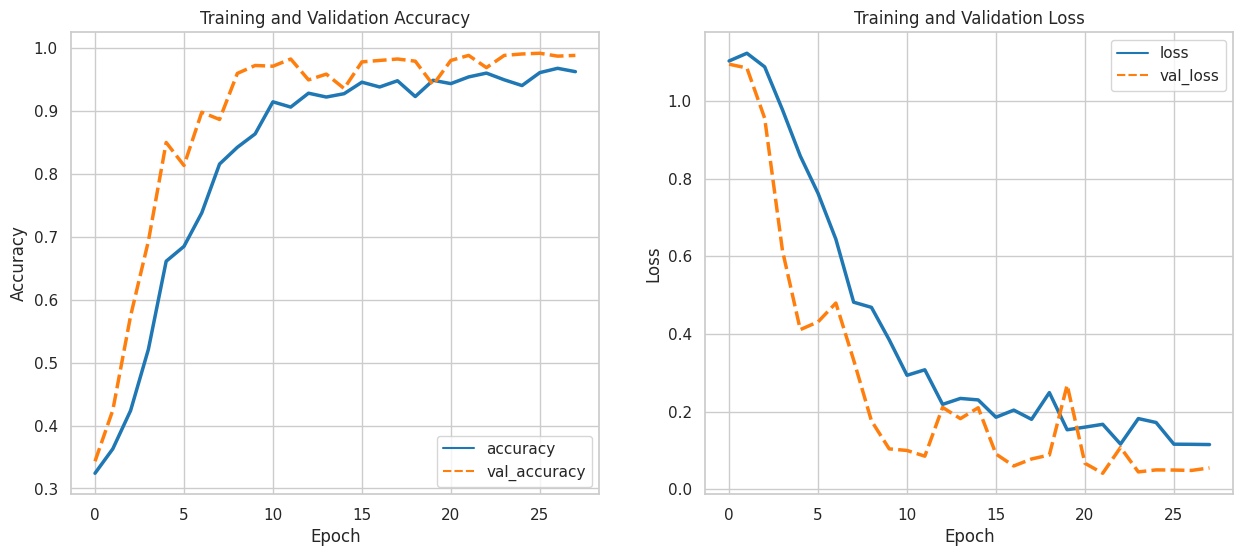

In [9]:
# Membuat DataFrame dari history
history_df = pd.DataFrame(history.history)

# Membuat plot menggunakan Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))

# Subplot Akurasi
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], palette="tab10", linewidth=2.5)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Subplot Loss
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['loss', 'val_loss']], palette="tab10", linewidth=2.5)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

28/28 [==============================] - 3s 99ms/step


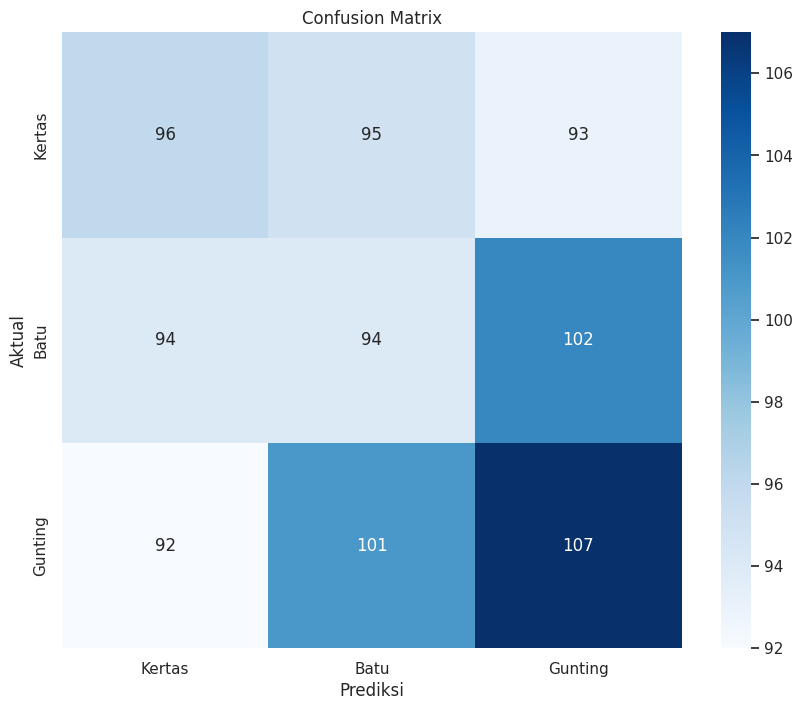

              precision    recall  f1-score   support

      Kertas       0.34      0.34      0.34       284
        Batu       0.32      0.32      0.32       290
     Gunting       0.35      0.36      0.36       300

    accuracy                           0.34       874
   macro avg       0.34      0.34      0.34       874
weighted avg       0.34      0.34      0.34       874



In [10]:
# Mendefinisikan kelas
classes = ["Kertas", "Batu", "Gunting"]

# Memprediksi kelas dari data validasi
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Menghitung confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Menampilkan matriks kebingungan dalam heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

# Melihat laporan klasifikasi
print(classification_report(y_true, y_pred_classes, target_names=classes))


In [11]:
# Evaluasi performa model
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Menampilkan hasil evaluasi
print(f'Akurasi: {accuracy:.4f}')
print(f'Presisi: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Akurasi: 0.3398
Presisi: 0.3398
Recall: 0.3398
F1-score: 0.3398


# **Memprediksi Gambar**

Saving 2f25VA1nfxiC86xj.png to 2f25VA1nfxiC86xj (1).png
Saving 3bkC6JAPog7xX9WO.png to 3bkC6JAPog7xX9WO (1).png
Saving 3tNHP8R9YHru011u.png to 3tNHP8R9YHru011u (1).png
Saving a9YV7Tzoj751vTun.png to a9YV7Tzoj751vTun (1).png
Saving Bv1IS98JTiuZC7Bs.png to Bv1IS98JTiuZC7Bs (1).png
Saving hAcc7l7XQ9EtxxfR.png to hAcc7l7XQ9EtxxfR (1).png
Saving KCh0XBlgDa526pBe.png to KCh0XBlgDa526pBe (1).png
Saving pBRSGgUENwGb83VQ.png to pBRSGgUENwGb83VQ (1).png
Saving uHBQbKd9VTYWdctJ.png to uHBQbKd9VTYWdctJ (1).png
Saving Y0XtXW0pn979O6KK.png to Y0XtXW0pn979O6KK (1).png
Saving zb6wXq49QppiS9sf.png to zb6wXq49QppiS9sf (1).png
Saving znR0vgP11p6yX3nI.png to znR0vgP11p6yX3nI (1).png
1/1 [==============================] - 0s 29ms/step


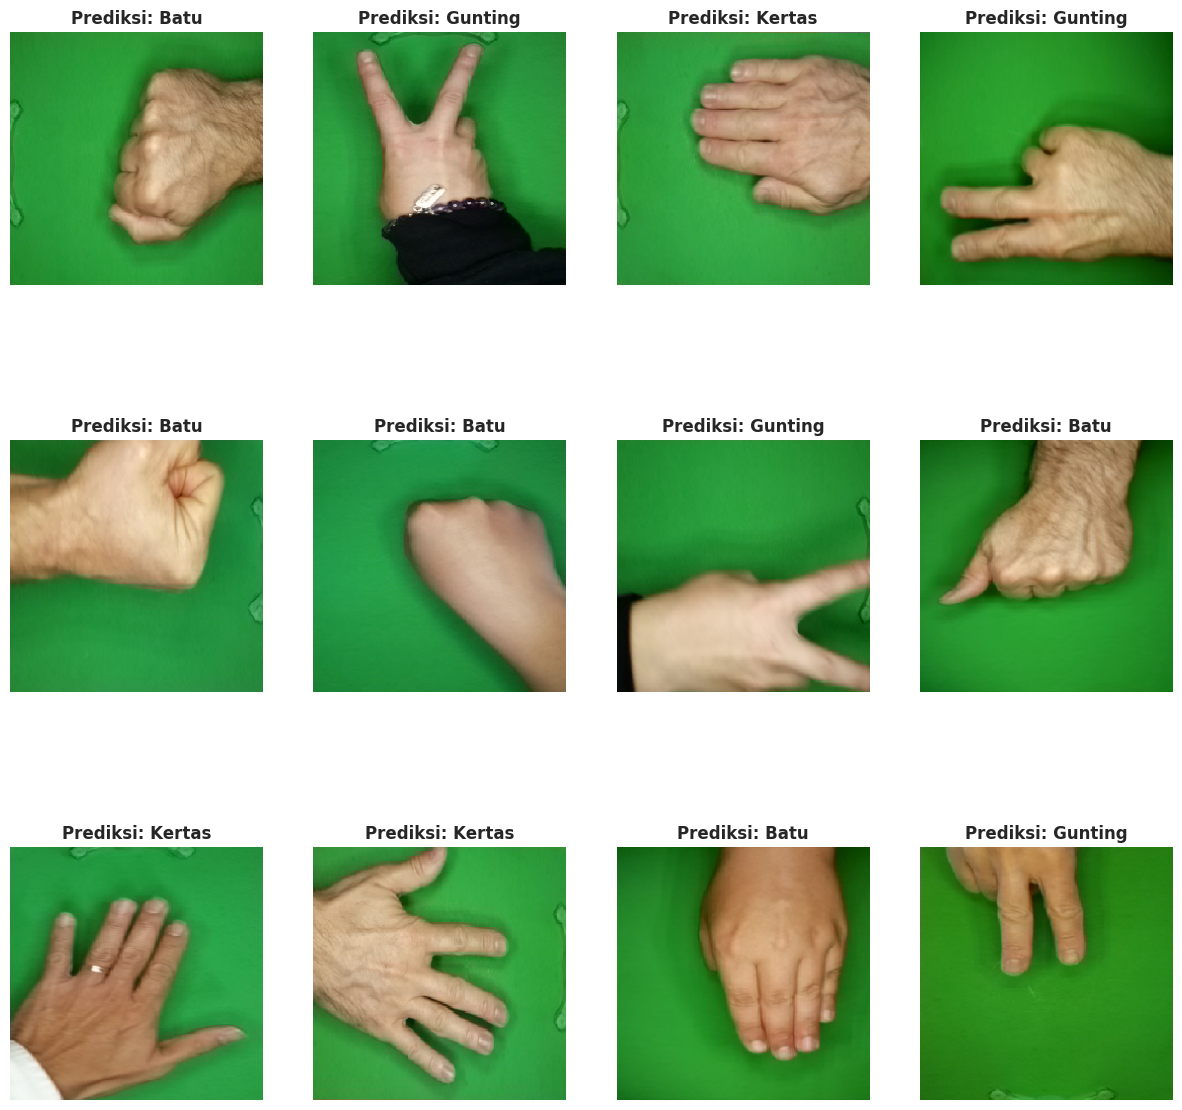

In [12]:
# Mengunggah gambar
uploaded = files.upload()

# Menghitung jumlah baris dan kolom berdasarkan jumlah gambar
total_uploaded = len(uploaded.keys())
num_cols = int(np.ceil(np.sqrt(total_uploaded)))
num_rows = int(np.ceil(total_uploaded / num_cols))

# Membuat subplot dengan ukuran yang disesuaikan
plt.figure(figsize=(15, 15))

# Fungsi untuk memprediksi dan menampilkan gambar
def predict_and_display(img_path, model, classes, index, total, num_cols):
  img = image.load_img(img_path, target_size=(256, 256))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 256.0  # Normalisasi
  result = model.predict(img_array)

  predicted_class_index = np.argmax(result[0])
  predicted_class = classes[predicted_class_index]

  # Menampilkan gambar dan hasil prediksi dalam subplot
  plt.subplot(num_rows, num_cols, index)
  sns.set(style="whitegrid")
  plt.imshow(img)
  plt.title(f"Prediksi: {predicted_class}", fontweight='bold')
  plt.axis('off')

# Memprediksi dan menampilkan gambar dalam subplot
for index, fn in enumerate(uploaded.keys(), start=1):
  predict_and_display(fn, model, classes, index, total_uploaded, num_cols)

plt.show()